C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:147: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f0 /= np.trapz(f0, x)
C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  D = np.trapz(np.exp(wG * G) * f, x)
C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(f, x)


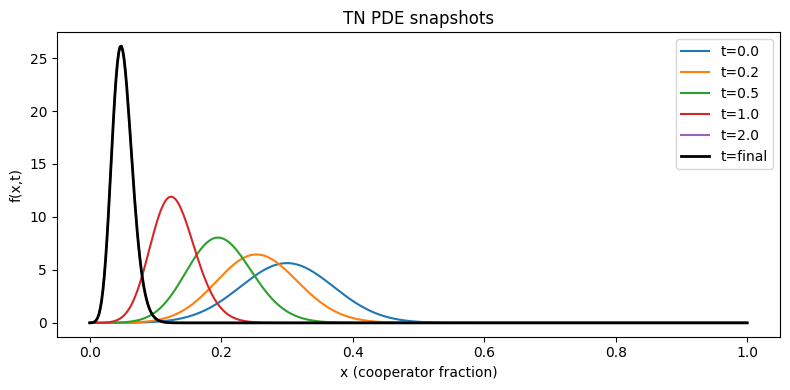

C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:67: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean_x = np.trapz(x * f, x)
C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:68: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  var_x = np.trapz((x - mean_x)**2 * f, x)
C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:69: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  meanG = np.trapz(G * f, x)
C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:72: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  entropy = -np.trapz(f * np.log(f + eps), x)


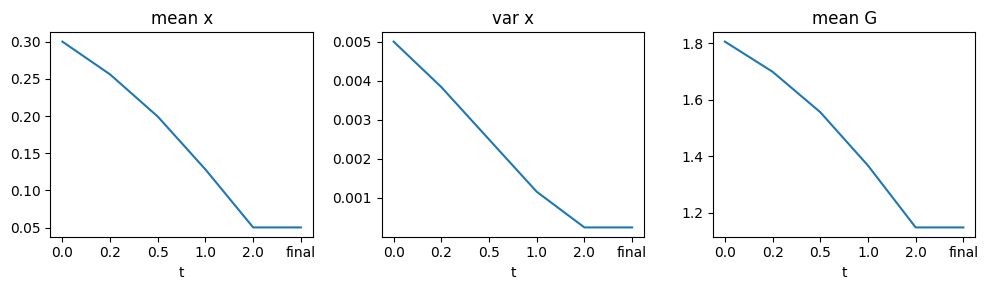

C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:83: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean_x = np.trapz(x * f_final, x)


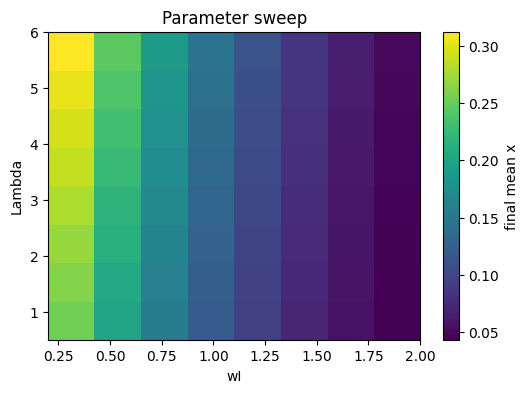

C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:92: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f /= np.trapz(f, x)
C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:100: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  D = np.trapz(np.exp(wG * G) * f, x)
C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:105: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f /= np.trapz(f, x)
C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:109: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  meanxs.append(np.trapz(x*f,x))


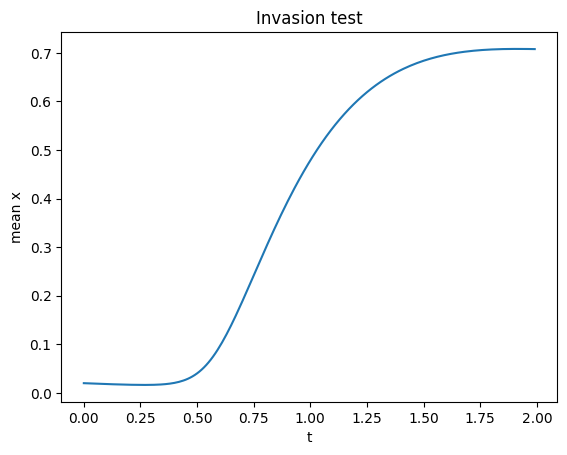

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def fitnesses(x, R, S, T, P):
    piC = R * x + S * (1 - x)
    piD = T * x + P * (1 - x)
    G = piC * x + piD * (1 - x)
    return piC, piD, G

def upwind_step(f, x, dx, dt, v, growth):
    """One conservative upwind step for -∂x(v f) + growth*f.
       v: velocity array on grid points, growth: growth rate array on grid points.
    """
    v_plus = np.maximum(v, 0.0)
    v_minus = np.minimum(v, 0.0)

    flux = v_plus * f + np.roll(v_minus * f, -1)
    flux[-1] = 0.0
    div = (flux - np.roll(flux, 1)) / dx
    dfdt = -div + growth * f
    return dfdt

def run_pde(R, S, T, P, Lambda, wI, wG,
            x, dt, tmax, f0,
            save_times):
    dx = x[1] - x[0]
    f = f0.copy()
    t = 0.0
    snapshots = {}
    times_to_save = set(save_times)
    # store initial if requested
    if 0.0 in times_to_save:
        snapshots[0.0] = f.copy()

    nsteps = int(np.ceil(tmax / dt))
    for step in range(nsteps):
        piC, piD, G = fitnesses(x, R, S, T, P)
        v = wI * x * (1 - x) * (piC - piD)          # within-group velocity
        # Traulsen-Nowak exponential group fitness:
        D = np.trapz(np.exp(wG * G) * f, x)
        growth = Lambda * (np.exp(wG * G) / D - 1.0)

        dfdt = upwind_step(f, x, dx, dt, v, growth)
        f = f + dt * dfdt

        # positivity and renormalize
        f = np.maximum(f, 0.0)
        total = np.trapz(f, x)
        if total <= 0:
            # numerical collapse guard
            f = np.ones_like(f) / (x[-1] - x[0])
            total = np.trapz(f, x)
        f /= total

        t += dt
        # save near requested times (use tolerance)
        for st in save_times:
            if abs(t - st) < 0.5*dt:
                snapshots[st] = f.copy()
    # ensure we have last time
    snapshots['final'] = f.copy()
    return snapshots

# Diagnostics: moments, mean G, entropy ???
def diagnostics(x, f, R, S, T, P):
    piC, piD, G = fitnesses(x, R, S, T, P)
    mean_x = np.trapz(x * f, x)
    var_x = np.trapz((x - mean_x)**2 * f, x)
    meanG = np.trapz(G * f, x)
    # Shannon-like entropy
    eps = 1e-12
    entropy = -np.trapz(f * np.log(f + eps), x)
    return {'mean_x': mean_x, 'var_x': var_x, 'meanG': meanG, 'entropy': entropy}

def sweep_Lambda_wI(L_vals, wI_vals, R,S,T,P, wG, x, dt, tmax, f0):
    heat = np.zeros((len(L_vals), len(wI_vals)))
    for i,L in enumerate(L_vals):
        for j,wI in enumerate(wI_vals):
            snaps = run_pde(R,S,T,P, Lambda=L, wI=wI, wG=wG,
                            x=x, dt=dt, tmax=tmax, f0=f0,
                            save_times=[tmax])
            f_final = snaps.get(tmax, snaps['final'])
            mean_x = np.trapz(x * f_final, x)
            heat[i,j] = mean_x
    return heat

# Invasion test: start near x=0 (almost all defectors) with tiny coop mass
def invasion_test(R,S,T,P, Lambda, wI, wG, x, dt, tmax):
    # initial: bulk at x=0 plus tiny gaussian near small x0
    f = np.ones_like(x) * 1e-6
    f += np.exp(-(x - 0.02)**2 / (2*(0.005**2)))  # tiny coop blob around 0.02
    f /= np.trapz(f, x)
    times = []
    meanxs = []
    t=0.0
    nsteps = int(np.ceil(tmax/dt))
    for step in range(nsteps):
        piC, piD, G = fitnesses(x, R, S, T, P)
        v = wI * x * (1-x) * (piC - piD)
        D = np.trapz(np.exp(wG * G) * f, x)
        growth = Lambda * (np.exp(wG * G) / D - 1.0)
        dfdt = upwind_step(f, x, x[1]-x[0], dt, v, growth)
        f = f + dt * dfdt
        f = np.maximum(f, 0.0)
        f /= np.trapz(f, x)
        t += dt
        if step % max(1, nsteps//200) == 0:
            times.append(t)
            meanxs.append(np.trapz(x*f,x))
    return np.array(times), np.array(meanxs), f

# first graph, f vs x in different t(similar with previous)
def plot_snapshots(x, snapshots, title=None):
    plt.figure(figsize=(8,4))
    for k in sorted(snapshots.keys(), key=lambda v: (v!='final', v)):
        if k=='final': continue
        plt.plot(x, snapshots[k], label=f"t={k}")
    plt.plot(x, snapshots['final'], label="t=final", lw=2, color='k')
    plt.xlabel('x (cooperator fraction)')
    plt.ylabel('f(x,t)')
    if title: plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_diagnostics(time_points, diag_list):
    means = [d['mean_x'] for d in diag_list]
    var = [d['var_x'] for d in diag_list]
    meanG = [d['meanG'] for d in diag_list]
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1); plt.plot(time_points, means); plt.xlabel('t'); plt.title('mean x')
    plt.subplot(1,3,2); plt.plot(time_points, var); plt.xlabel('t'); plt.title('var x')
    plt.subplot(1,3,3); plt.plot(time_points, meanG); plt.xlabel('t'); plt.title('mean G')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    R,S,T,P = 3.0, 0.0, 5.0, 1.0
    Lambda = 3.0
    wI = 1.0
    wG = 1.0
    x = np.linspace(0,1,500)
    dt = 5e-4
    tmax = 2.0

    f0 = np.exp(-((x - 0.3) ** 2) / 0.01)
    f0 /= np.trapz(f0, x)
    save_times = [0.0, 0.2, 0.5, 1.0, tmax]
    snaps = run_pde(R,S,T,P, Lambda, wI, wG, x, dt, tmax, f0, save_times)
    plot_snapshots(x, snaps, title="TN PDE snapshots")

    float_keys = sorted([k for k in snaps.keys() if isinstance(k, float)])
    diag_list = [diagnostics(x, snaps[t], R,S,T,P) for t in float_keys]
    diag_list.append(diagnostics(x, snaps['final'], R,S,T,P))
    times_sorted = float_keys + ['final']
    plot_diagnostics(times_sorted, diag_list)

    L_vals = np.linspace(0.5, 6.0, 8)
    wI_vals = np.linspace(0.2, 2.0, 8)
    heat = sweep_Lambda_wI(L_vals, wI_vals, R,S,T,P, wG, x, dt, 1.0, f0)
    plt.figure(figsize=(6,4)); plt.imshow(heat, origin='lower',
               extent=[wI_vals[0], wI_vals[-1], L_vals[0], L_vals[-1]], aspect='auto')
    plt.colorbar(label='final mean x'); plt.xlabel('wI'); plt.ylabel('Lambda'); plt.title('Parameter sweep'); plt.show()

    # invasion test(begin when x=0, and see the chaning of x)
    times, meanxs, f_end = invasion_test(R,S,T,P, Lambda, wI, wG, x, dt, 2.0)
    plt.plot(times, meanxs); plt.xlabel('t'); plt.ylabel('mean x'); plt.title('Invasion test'); plt.show()


In [13]:
# calculate the Λc, to resist that mutation destroy the coorperation(f0<f2)
import numpy as np
from scipy import linalg
from scipy.optimize import brentq

#M
def build_M(Lambda, mu, params):
    w_I = params.get('w_I', 0.1)
    w_G = params.get('w_G', 0.1)
    T = params.get('T', 5.0)
    S = params.get('S', 0.0)
    P = params.get('P', 1.0)
    R = params.get('R', 3.0)
    
    a00 = -mu * (1 + w_I * P) + Lambda * w_G * P
    a01 = (1 - mu) * (1 + w_I * T)
    a02 = 0.0

    a10 = mu * (1 + w_I * P)
    a11 = - (1 - mu) * (2 + w_I * (T + S)) + Lambda * w_G * ((T + S) / 2.0)
    a12 = mu * (1 + w_I * R)

    a20 = 0.0
    a21 = (1 - mu) * (1 + w_I * S)
    a22 = -mu * (1 + w_I * R) + Lambda * w_G * R

    M = np.array([[a00, a01, a02],
                  [a10, a11, a12],
                  [a20, a21, a22]], dtype=float)
    return M


def principal_eigvec_normalized(M, tol_imag=1e-8):
    vals, vecs = linalg.eig(M)
    idx = np.argmax(vals.real)
    v = vecs[:, idx]
    # if np.max(np.abs(v.imag)) > tol_imag:
    #     print("WARNING: principal eigenvector has non-negligible imaginary part; taking real part.")
    v_real = v.real
    s = np.sum(v_real)
    if np.isclose(s, 0.0):
        s = np.sum(np.abs(v_real))
        if np.isclose(s, 0.0):
            raise ValueError("Principal eigenvector sums to zero; cannot normalize.")
        f = v_real / s
    else:
        f = v_real / s
    return f, vals[idx]

def g_of_Lambda(Lambda, mu, params):
    M = build_M(Lambda, mu, params)
    f, eigval = principal_eigvec_normalized(M)
    g = f[2] - f[0]
    return g

def find_Lambda_c(mu, params,
                  Lambda_min=0.0, Lambda_max=10.0,
                  n_scan=1001, tol=1e-6):
    Lambdas = np.linspace(Lambda_min, Lambda_max, n_scan)
    gvals = np.empty_like(Lambdas)
    for i, L in enumerate(Lambdas):
        try:
            gvals[i] = g_of_Lambda(L, mu, params)
        except Exception as e:
            gvals[i] = np.nan
    idx_valid = np.where(~np.isnan(gvals))[0]
    if idx_valid.size == 0:
        return None
    for k in range(len(Lambdas) - 1):
        a, b = gvals[k], gvals[k+1]
        if np.isnan(a) or np.isnan(b):
            continue
        if a == 0.0:
            return Lambdas[k]
        if a * b < 0:
            L_lo, L_hi = Lambdas[k], Lambdas[k+1]
            try:
                root = brentq(lambda L: g_of_Lambda(L, mu, params), L_lo, L_hi, xtol=tol)
                return root
            except Exception as e:
                return 0.5 * (L_lo + L_hi)
    return None

def compute_Lambda_c_for_mu_list(mu_list, params, Lambda_min=0.0, Lambda_max=10.0):
    results = []
    for mu in mu_list:
        try:
            lc = find_Lambda_c(mu, params, Lambda_min=Lambda_min, Lambda_max=Lambda_max)
            results.append((mu, lc))
            print(f"mu={mu:.5f}  -> Lambda_c = {lc}")
        except Exception as e:
            results.append((mu, None))
            print(f"mu={mu:.5f}  -> failed: {e}")
    return results

if __name__ == "__main__":
    params = {
        'w_I': 0.1,
        'w_G': 0.1,
        'T': 5.0,
        'S': 0.0,
        'P': 1.0,
        'R': 3.0
    }
    mu_vals = np.linspace(0.0, 0.05, 6)
    results = compute_Lambda_c_for_mu_list(mu_vals, params, Lambda_min=0.0, Lambda_max=20.0)


mu=0.00000  -> Lambda_c = None
mu=0.01000  -> Lambda_c = 0.03401642468555937
mu=0.02000  -> Lambda_c = 0.06806612024811277
mu=0.03000  -> Lambda_c = 0.10214978653287958
mu=0.04000  -> Lambda_c = 0.13626791508950092
mu=0.05000  -> Lambda_c = 0.17042135562452146


C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:143: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f0 /= np.trapz(f0, x)
C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  D = np.trapz(np.exp(wG * G) * f, x)
C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(f, x)


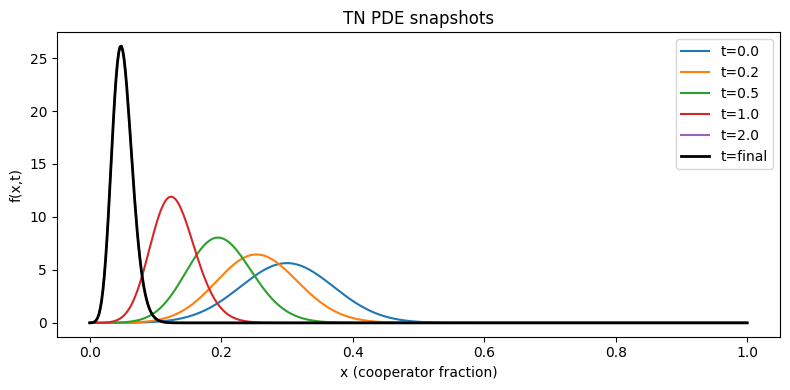

C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:63: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean_x = np.trapz(x * f, x)
C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:64: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  var_x = np.trapz((x - mean_x)**2 * f, x)
C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  meanG = np.trapz(G * f, x)
C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:68: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  entropy = -np.trapz(f * np.log(f + eps), x)


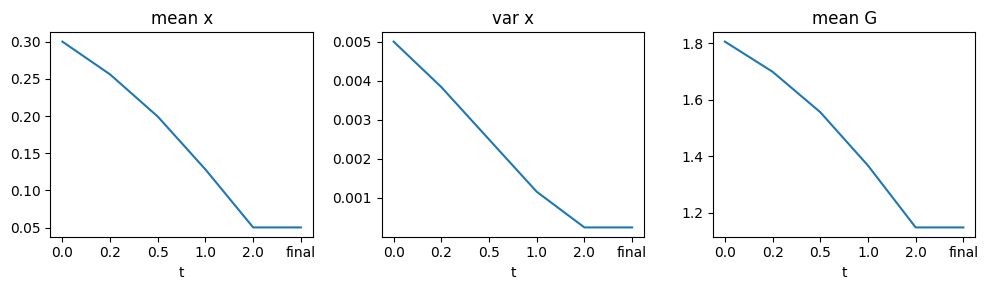

C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:79: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean_x = np.trapz(x * f_final, x)


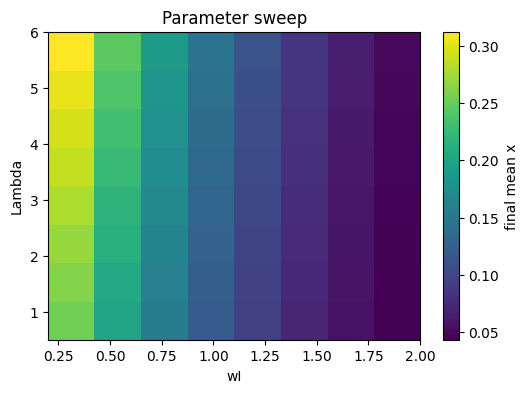

C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:88: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f /= np.trapz(f, x)
C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:96: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  D = np.trapz(np.exp(wG * G) * f, x)
C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:101: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f /= np.trapz(f, x)
C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:105: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  meanxs.append(np.trapz(x*f,x))


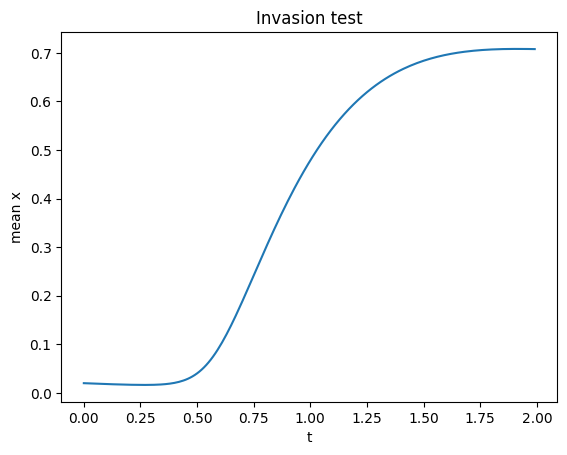

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def fitnesses(x, R, S, T, P):
    piC = R * x + S * (1 - x)
    piD = T * x + P * (1 - x)
    G = piC * x + piD * (1 - x)
    return piC, piD, G

def upwind_step(f, x, dx, dt, v, growth):
    """One conservative upwind step for -∂x(v f) + growth*f.
       v: velocity array on grid points, growth: growth rate array on grid points.
    """
    v_plus = np.maximum(v, 0.0)
    v_minus = np.minimum(v, 0.0)

    flux = v_plus * f + np.roll(v_minus * f, -1) # flux[i] = (vf)_{i+1/2}
    flux[-1] = 0.0
    div = (flux - np.roll(flux, 1)) / dx # (vf)_{i+1/2} - (vf)_{i-1/2}
    dfdt = -div + growth * f
    return dfdt

def run_pde(R, S, T, P, Lambda, wI, wG,
            x, dt, tmax, f0,
            save_times):
    dx = x[1] - x[0]
    f = f0.copy()
    t = 0.0
    snapshots = {}
    times_to_save = set(save_times)
    # store initial if requested
    if 0.0 in times_to_save:
        snapshots[0.0] = f.copy()

    nsteps = int(np.ceil(tmax / dt))
    for step in range(nsteps):
        piC, piD, G = fitnesses(x, R, S, T, P)
        v = wI * x * (1 - x) * (piC - piD)
        D = np.trapz(np.exp(wG * G) * f, x)
        growth = Lambda * (np.exp(wG * G) / D - 1.0)

        dfdt = upwind_step(f, x, dx, dt, v, growth)
        f = f + dt * dfdt

        # positivity and renormalize
        f = np.maximum(f, 0.0)
        total = np.trapz(f, x)
        if total <= 0:
            f = np.ones_like(f) / (x[-1] - x[0])
            total = np.trapz(f, x)
        f /= total
        t += dt
        for st in save_times:
            if abs(t - st) < 0.5*dt:
                snapshots[st] = f.copy()
    # ensure we have last time
    snapshots['final'] = f.copy()
    return snapshots

# Diagnostics: moments, mean G, entropy ???
def diagnostics(x, f, R, S, T, P):
    piC, piD, G = fitnesses(x, R, S, T, P)
    mean_x = np.trapz(x * f, x)
    var_x = np.trapz((x - mean_x)**2 * f, x)
    meanG = np.trapz(G * f, x)
    # Shannon-like entropy
    eps = 1e-12
    entropy = -np.trapz(f * np.log(f + eps), x)
    return {'mean_x': mean_x, 'var_x': var_x, 'meanG': meanG, 'entropy': entropy}

def sweep_Lambda_wI(L_vals, wI_vals, R,S,T,P, wG, x, dt, tmax, f0):
    heat = np.zeros((len(L_vals), len(wI_vals)))
    for i,L in enumerate(L_vals):
        for j,wI in enumerate(wI_vals):
            snaps = run_pde(R,S,T,P, Lambda=L, wI=wI, wG=wG,
                            x=x, dt=dt, tmax=tmax, f0=f0,
                            save_times=[tmax])
            f_final = snaps.get(tmax, snaps['final'])
            mean_x = np.trapz(x * f_final, x)
            heat[i,j] = mean_x
    return heat

# Invasion test: start near x=0 (almost all defectors) with tiny coop mass
def invasion_test(R,S,T,P, Lambda, wI, wG, x, dt, tmax):
    # initial: bulk at x=0 plus tiny gaussian near small x0
    f = np.ones_like(x) * 1e-6
    f += np.exp(-(x - 0.02)**2 / (2*(0.005**2)))  # tiny coop blob around 0.02
    f /= np.trapz(f, x)
    times = []
    meanxs = []
    t=0.0
    nsteps = int(np.ceil(tmax/dt))
    for step in range(nsteps):
        piC, piD, G = fitnesses(x, R, S, T, P)
        v = wI * x * (1-x) * (piC - piD)
        D = np.trapz(np.exp(wG * G) * f, x)
        growth = Lambda * (np.exp(wG * G) / D - 1.0)
        dfdt = upwind_step(f, x, x[1]-x[0], dt, v, growth)
        f = f + dt * dfdt
        f = np.maximum(f, 0.0)
        f /= np.trapz(f, x)
        t += dt
        if step % max(1, nsteps//200) == 0:
            times.append(t)
            meanxs.append(np.trapz(x*f,x))
    return np.array(times), np.array(meanxs), f

# first graph, f vs x in different t(similar with previous)
def plot_snapshots(x, snapshots, title=None):
    plt.figure(figsize=(8,4))
    for k in sorted(snapshots.keys(), key=lambda v: (v!='final', v)):
        if k=='final': continue
        plt.plot(x, snapshots[k], label=f"t={k}")
    plt.plot(x, snapshots['final'], label="t=final", lw=2, color='k')
    plt.xlabel('x (cooperator fraction)')
    plt.ylabel('f(x,t)')
    if title: plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_diagnostics(time_points, diag_list):
    means = [d['mean_x'] for d in diag_list]
    var = [d['var_x'] for d in diag_list]
    meanG = [d['meanG'] for d in diag_list]
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1); plt.plot(time_points, means); plt.xlabel('t'); plt.title('mean x')
    plt.subplot(1,3,2); plt.plot(time_points, var); plt.xlabel('t'); plt.title('var x')
    plt.subplot(1,3,3); plt.plot(time_points, meanG); plt.xlabel('t'); plt.title('mean G')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    R,S,T,P = 3.0, 0.0, 5.0, 1.0
    Lambda = 3.0
    wI = 1.0
    wG = 1.0
    x = np.linspace(0,1,500)
    dt = 5e-4
    tmax = 2.0

    f0 = np.exp(-((x - 0.3) ** 2) / 0.01)
    f0 /= np.trapz(f0, x)
    save_times = [0.0, 0.2, 0.5, 1.0, tmax]
    snaps = run_pde(R,S,T,P, Lambda, wI, wG, x, dt, tmax, f0, save_times)
    plot_snapshots(x, snaps, title="TN PDE snapshots")

    float_keys = sorted([k for k in snaps.keys() if isinstance(k, float)])
    diag_list = [diagnostics(x, snaps[t], R,S,T,P) for t in float_keys]
    diag_list.append(diagnostics(x, snaps['final'], R,S,T,P))
    times_sorted = float_keys + ['final']
    plot_diagnostics(times_sorted, diag_list)

    L_vals = np.linspace(0.5, 6.0, 8)
    wI_vals = np.linspace(0.2, 2.0, 8)
    heat = sweep_Lambda_wI(L_vals, wI_vals, R,S,T,P, wG, x, dt, 1.0, f0)
    plt.figure(figsize=(6,4)); plt.imshow(heat, origin='lower',
               extent=[wI_vals[0], wI_vals[-1], L_vals[0], L_vals[-1]], aspect='auto')
    plt.colorbar(label='final mean x'); plt.xlabel('wI'); plt.ylabel('Lambda'); plt.title('Parameter sweep'); plt.show()

    # invasion test(begin when x=0, and see the chaning of x)
    times, meanxs, f_end = invasion_test(R,S,T,P, Lambda, wI, wG, x, dt, 2.0)
    plt.plot(times, meanxs); plt.xlabel('t'); plt.ylabel('mean x'); plt.title('Invasion test'); plt.show()


In [3]:
import sympy as sp
from sympy import symbols, simplify
from sympy import ratsimp
# 定义符号
f0, f1, f2 = sp.symbols('f0 f1 f2', real=True, nonnegative=True)
Lambda, a, b, c, d, e = sp.symbols('Lambda a b c d e', real=True)
omega_G, P, G1, G2, D = sp.symbols('omega_G P G1 G2 D', real=True, positive=True)

# f3 用约束代替
f3 = 1 - f0 - f1 - f2

# df0/dt
df0 = (1-Lambda)*(- f0*a + f1*b) + Lambda*f0*(sp.exp(omega_G*P)/D - 1)

# df1/dt
df1 = (1-Lambda)*(- f1*(c+2*b) + f0*a + 2*f2*d) + Lambda*f1*(sp.exp(omega_G*G1)/D - 1)

# df2/dt
df2 = (1-Lambda)*(- f2*(2*e + d) + 2*f1*b + f3) + Lambda*f2*(sp.exp(omega_G*G2)/D - 1)

# 求解 df/dt = 0
sol = sp.solve([df0, df1, df2], (f0, f1, f2), dict=True)

# 对每个解字典里的表达式进行 simplify
sol = sp.solve([df0, df1, df2], (f0, f1, f2), dict=True)

sol_simplified = []
for s in sol:
    s_simpl = {var: ratsimp(expr) for var, expr in s.items()}
    sol_simplified.append(s_simpl)

for s in sol_simplified:
    for var, expr in s.items():
        print(f"{var} = {expr}")

f0 = (-2*D**3*Lambda**3*b*d + 6*D**3*Lambda**2*b*d - 6*D**3*Lambda*b*d + 2*D**3*b*d)/(3*D**3*Lambda**3*a*b*d - 2*D**3*Lambda**3*a*b*e - D**3*Lambda**3*a*c*d - 2*D**3*Lambda**3*a*c*e - D**3*Lambda**3*a*d + 2*D**3*Lambda**3*a*e - 4*D**3*Lambda**3*b*d + 4*D**3*Lambda**3*b*e + D**3*Lambda**3*c*d + 2*D**3*Lambda**3*c*e + D**3*Lambda**3*d - 2*D**3*Lambda**3*e - 9*D**3*Lambda**2*a*b*d + 6*D**3*Lambda**2*a*b*e + D**3*Lambda**2*a*b + 3*D**3*Lambda**2*a*c*d + 6*D**3*Lambda**2*a*c*e + D**3*Lambda**2*a*c + 4*D**3*Lambda**2*a*d - 4*D**3*Lambda**2*a*e - D**3*Lambda**2*a + 10*D**3*Lambda**2*b*d - 8*D**3*Lambda**2*b*e - 2*D**3*Lambda**2*b - 2*D**3*Lambda**2*c*d - 4*D**3*Lambda**2*c*e - D**3*Lambda**2*c - 3*D**3*Lambda**2*d + 2*D**3*Lambda**2*e + D**3*Lambda**2 + 9*D**3*Lambda*a*b*d - 6*D**3*Lambda*a*b*e - 2*D**3*Lambda*a*b - 3*D**3*Lambda*a*c*d - 6*D**3*Lambda*a*c*e - 2*D**3*Lambda*a*c - 5*D**3*Lambda*a*d + 2*D**3*Lambda*a*e + D**3*Lambda*a - 8*D**3*Lambda*b*d + 4*D**3*Lambda*b*e + 2*D**3*Lambda*b + D

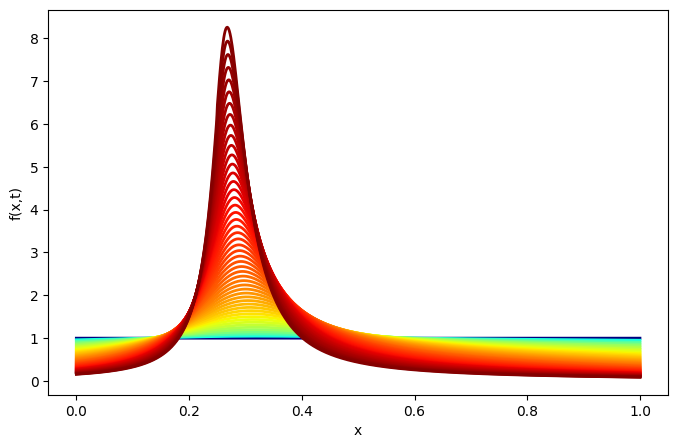

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


N = 800
dt = 0.0005
time_steps = 5000
wi = 1
wg = 1
Lambda = 0.1
# R, S, T, P = 6, 3, 12, 5 #PD
R, S, T, P = 6, 5, 12, 3 #HD

x_interface = np.linspace(0, 1, N+1)
dx = x_interface[1] - x_interface[0]
x_center = 0.5 * (x_interface[1:] + x_interface[:-1])


def theta_init(j, N, theta):
    return N ** (1.0 - theta) * (((N - j) ** theta) - ((N - j - 1.0) ** theta))
theta_vec = np.vectorize(theta_init)
index_holder = np.arange(N, dtype=float)
f_j = theta_vec(index_holder, N, 1.0)
f_j /= np.sum(f_j * dx)


def coop_payoff(x):
    numer = np.exp(wi * (x*R + (1-x)*S))
    denom = np.exp(wi * (x*R + (1-x)*S)) + np.exp(wi * (x*T + (1-x)*P))
    return numer / denom

def def_payoff(x):
    numer = np.exp(wi * (x*T + (1-x)*P))
    denom = np.exp(wi * (x*R + (1-x)*S)) + np.exp(wi * (x*T + (1-x)*P))
    return numer / denom

def G(x):
    return x * (x*R + (1-x)*S) + (1-x)*(x*T + (1-x)*P)

# def G_group(f):
#     exp_wgG_centers = np.exp(wg * G(x_center))
#     denom = np.sum(f * exp_wgG_centers) * dx
#     if denom == 0:
#         denom = 1e-20
#     return exp_wgG_centers / denom 

def flux(f):
    F = np.zeros(N+1)
    for j in range(N+1):
        x = x_interface[j]
        v = x*(1-x)*(coop_payoff(x)-def_payoff(x))
        
        if v >= 0:
            f_up = f[j-1] if j>0 else f[0]
        else:
            f_up = f[j] if j<N else f[-1]
        F[j] = v * f_up
    return F

def cell_trapz_integrals_local(f):
    I = np.zeros(N)
    J = np.zeros(N)
    
    denom = np.sum(f * np.exp(wg * G(x_center))) * dx
    if denom == 0:
        denom = 1e-20

    for j in range(N):
        xL, xR = x_interface[j], x_interface[j+1]
        fL, fR = f[j], f[j]
        if j < N-1:
            fR = f[j+1]
        
        G_L = np.exp(wg * G(xL)) / denom
        G_R = np.exp(wg * G(xR)) / denom
        I[j] = 0.5 * dx * (G_L * fL + G_R * fR)
        J[j] = 0.5 * dx * (fL + fR)
    
    return I, J


plt.figure(figsize=(8,5))

for n in range(time_steps):

    # G_vals = G_group(x_center)
    # df_selection = Lambda * (G_vals * f_j - f_j) * dx
    I_cell, J_cell = cell_trapz_integrals_local(f_j)
    df_selection = Lambda * (I_cell - J_cell)


    F = flux(f_j)
    df_transport = -(F[1:] - F[:-1])/dx

    f_j_new = f_j + dt * (df_transport + df_selection)
    f_j_new = np.maximum(f_j_new, 0)
    current_sum_f_j = np.sum(f_j_new)

    if current_sum_f_j > 0:
        f_j_new = f_j_new * (N / current_sum_f_j)
    else:
        f_j_new = np.ones_like(f_j_new)
        f_j_new = f_j_new * (N / np.sum(f_j_new))
    f_j = f_j_new
    
    if n % 100 == 0:
        color_val = cm.jet((n / time_steps)**0.25)
        plt.plot(x_center, f_j, color=color_val, lw=2)

plt.xlabel('x')
plt.ylabel('f(x,t)')
plt.show()


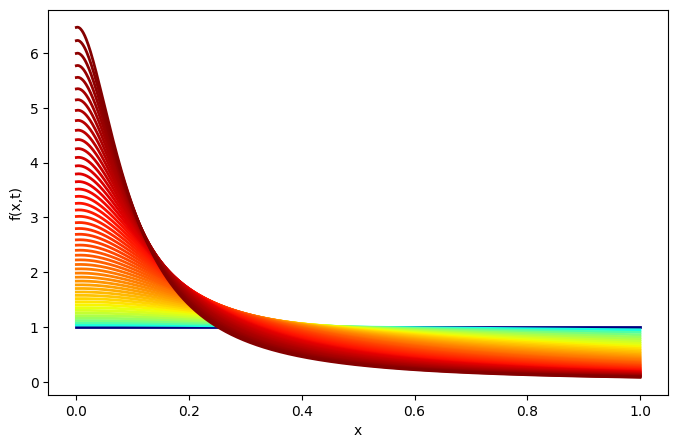

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


N = 800
dt = 0.0005
time_steps = 5000
wi = 1
wg = 1
Lambda = 0.1
R, S, T, P = 6, 3, 12, 5 #PD

x_interface = np.linspace(0, 1, N+1)
dx = x_interface[1] - x_interface[0]
x_center = 0.5 * (x_interface[1:] + x_interface[:-1])


def theta_init(j, N, theta):
    return N ** (1.0 - theta) * (((N - j) ** theta) - ((N - j - 1.0) ** theta))
theta_vec = np.vectorize(theta_init)
index_holder = np.arange(N, dtype=float)
f_j = theta_vec(index_holder, N, 1.0)
f_j /= np.sum(f_j * dx)


def coop_payoff(x):
    numer = np.exp(wi * (x*R + (1-x)*S))
    denom = np.exp(wi * (x*R + (1-x)*S)) + np.exp(wi * (x*T + (1-x)*P))
    return numer / denom

def def_payoff(x):
    numer = np.exp(wi * (x*T + (1-x)*P))
    denom = np.exp(wi * (x*R + (1-x)*S)) + np.exp(wi * (x*T + (1-x)*P))
    return numer / denom

def G(x):
    return x * (x*R + (1-x)*S) + (1-x)*(x*T + (1-x)*P)

def G_group(f):
    exp_wgG_centers = np.exp(wg * G(x_center))
    denom = np.sum(f * exp_wgG_centers) * dx
    if denom == 0:
        denom = 1e-20
    return exp_wgG_centers / denom

def flux(f):
    F = np.zeros(N+1)
    for j in range(N+1):
        x = x_interface[j]
        v = x*(1-x)*(coop_payoff(x)-def_payoff(x))

        if v >= 0:
            f_up = f[j-1] if j>0 else f[0]
        else:
            f_up = f[j] if j<N else f[-1]
        F[j] = v * f_up
    return F

def cell_trapz_integrals_local(f):
    I = np.zeros(N)
    J = np.zeros(N)

    denom = np.sum(f * np.exp(wg * G(x_center))) * dx
    if denom == 0:
        denom = 1e-20

    for j in range(N):
        xL, xR = x_interface[j], x_interface[j+1]
        fL, fR = f[j], f[j]
        if j < N-1:
            fR = f[j+1]

        G_L = np.exp(wg * G(xL)) / denom
        G_R = np.exp(wg * G(xR)) / denom
        I[j] = 0.5 * dx * (G_L * fL + G_R * fR)
        J[j] = 0.5 * dx * (fL + fR)

    return I, J


plt.figure(figsize=(8,5))

for n in range(time_steps):

    G_vals = G_group(x_center)
    df_selection = Lambda * (G_vals * f_j - f_j) * dx
    I_cell, J_cell = cell_trapz_integrals_local(f_j)
    df_selection = Lambda * (I_cell - J_cell)


    F = flux(f_j)
    df_transport = -(F[1:] - F[:-1])/dx

    f_j_new = f_j + dt * (df_transport + df_selection)
    f_j_new = np.maximum(f_j_new, 0)
    current_sum_f_j = np.sum(f_j_new)

    if current_sum_f_j > 0:
        f_j_new = f_j_new * (N / current_sum_f_j)
    else:
        f_j_new = np.ones_like(f_j_new)
        f_j_new = f_j_new * (N / np.sum(f_j_new))
    f_j = f_j_new

    if n % 100 == 0:
        color_val = cm.jet((n / time_steps)**0.25)
        plt.plot(x_center, f_j, color=color_val, lw=2)

plt.xlabel('x')
plt.ylabel('f(x,t)')
plt.show()


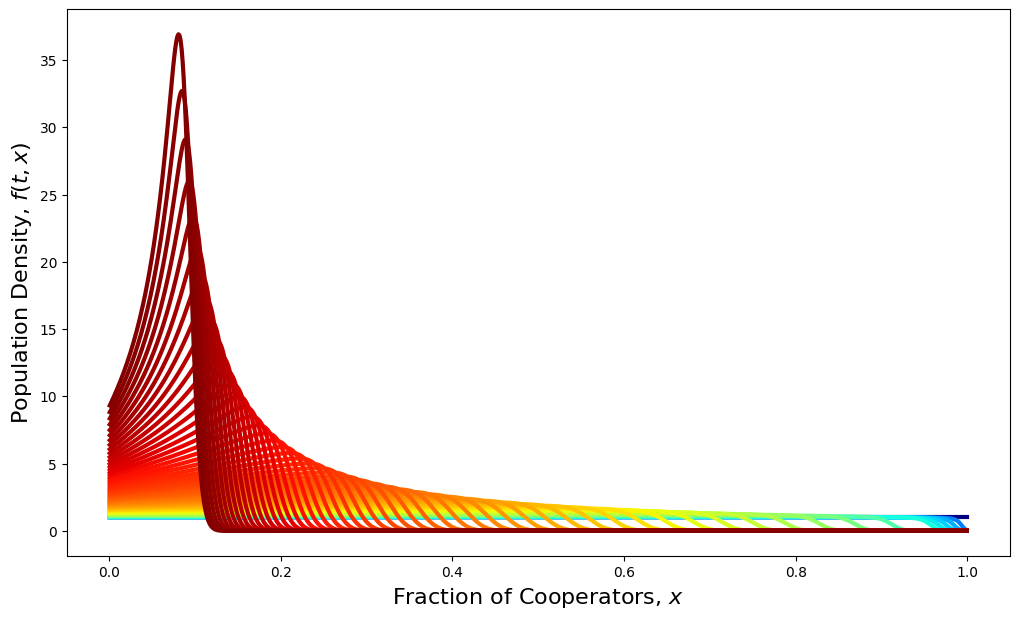

In [32]:
from logging import warning
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import os

plt.rc('text', usetex=False)


N = 800
wi = 1
wg = 1.0
Lambda = 0.1
R,S,T,P=6,3,12,5 #PD game for now

def theta_init(j,N,theta):
	return N ** (1.0 - theta) * (((N - j) ** theta) - ((N - j - 1.0) ** theta) )
theta_vec = np.vectorize(theta_init)

index_holder = np.zeros(N)
for j in range(N):
	index_holder[j] = j
	
f_j = np.ones(N)
f_j = theta_vec(index_holder,N,1.0)


def pi_C(x):
    return R * x + S * (1 - x)

def pi_D(x):
    return T * x + P * (1 - x)

def G(x):
    return pi_C(x) * x + pi_D(x) * (1 - x)

def coop_payoff(x):
    numer = np.exp(wi * pi_C(x))
    denom = x * numer + (1-x) * np.exp(wi * pi_D(x))
    return numer / denom

def def_payoff(x):
    numer = np.exp(wi * pi_D(x))
    denom = x * np.exp(wi * pi_C(x)) + (1-x) * numer
    return numer / denom


def avg_grp_payoff(x, f):
    """Compute 𝒢(x) = e^{wg G(x)} / ∑ f_j e^{wg G(x_j)} Δx."""
    numer = np.exp(wg * G(x))
    dx = 1.0 / N
    x_centers = (np.arange(N) + 0.5) / N
    w_all = np.exp(wg * G(x_centers))   # e^{wg G(x_j)} for all cells
    denom = dx * np.dot(f, w_all)       # sum_j f_j * w_j * dx
    return numer / denom

def trapozoid_G_integral_on_interval(j,f,N):
    val = f / (2*N) * (avg_grp_payoff(j/N, f) + avg_grp_payoff((j+1)/N, f))
    return val

def G_j(fj, j, N):
    return N * trapozoid_G_integral_on_interval(j,fj,N)

def G_j_vec(fj):
    # j indexes 0,...,N-1
    j = np.arange(N)
    x_left = j / N
    x_right = (j + 1) / N

    # trapezoid rule on each cell [j/N,(j+1)/N]
    cell_integral = fj * (avg_grp_payoff(x_left, fj) +
                         avg_grp_payoff(x_right, fj)) / (2 * N)

    # G_j = N * ∫_{cell j} 𝒢(x) f(x) dx
    return N * cell_integral    # shape (N,)


def righthand(fj, G_jvec):
    return fj * (G_jvec - 1.0)

# def flux(N):
#     dfdt = np.zeros_like(N + 1)
#     for j in range(1,N):
#           xjp1 = (j+1)/N
#           PC = coop_payoff(xjp1)
#           PD = def_payoff(xjp1)
#           dfdt[j] = xjp1 * (1-xjp1) * (PC - PD)

#     dfdt[0] = 0
#     dfdt[N] = 0

def flux_in_cal(j, N):
    xj = j / N
    PC = coop_payoff(xj)
    PD = def_payoff(xj)
    return xj * (1 - xj) * (PC - PD)

def flux_out_cal(j, N):
    xj = j / N
    PC = coop_payoff(xj)
    PD = def_payoff(xj)
    return xj * (1 - xj) * (PC - PD) 

flux_in_vec = np.vectorize(flux_in_cal)
flux_out_vec = np.vectorize(flux_out_cal)

def within_group(f,N,index_holder):
    left_roll = np.roll(f,-1)
    left_roll[-1] = 0.
    right_roll = np.roll(f,1)
    right_roll[0] = 0.

    #We are assuming we only perfrom PD game so far, so f(t,x_j+1) = f_j+1
    flux_in = flux_in_vec(index_holder + 1, N) * left_roll
    flux_out = flux_in_vec(index_holder, N) * f
    return N * (flux_out - flux_in)

G_jvec = np.vectorize(G_j) 

time_step = 0.0005  
time_length = 5000  
for time in range(time_length):
    if time % 100 == 0:
        plt.plot(np.arange(0.5/N,1.0+0.5/N,1.0/N),f_j, color = cmap.jet((float(time) / time_length)**.25), lw = 3.)
    elif time in [20,40,60,80,100]:
        plt.plot(np.arange(0.5/N,1.0+0.5/N,1.0/N),f_j, color = cmap.jet((float(time) / time_length)**.25), lw = 3.)
  
    # between_group_effect = righthand(f_j, G_jvec(f_j, index_holder, N))
    G_vals = G_j_vec(f_j)                        # shape (N,)
    between_group_effect = righthand(f_j, G_vals)
    within_group_effect = within_group(f_j,N,index_holder)

    righthand_side = within_group_effect + Lambda * between_group_effect
    f_j = f_j + time_step * righthand_side   



plt.tight_layout()
plt.xlabel('Fraction of Cooperators, $x$', fontsize=16)
plt.ylabel('Population Density, $f(t,x)$', fontsize=16)
plt.show()


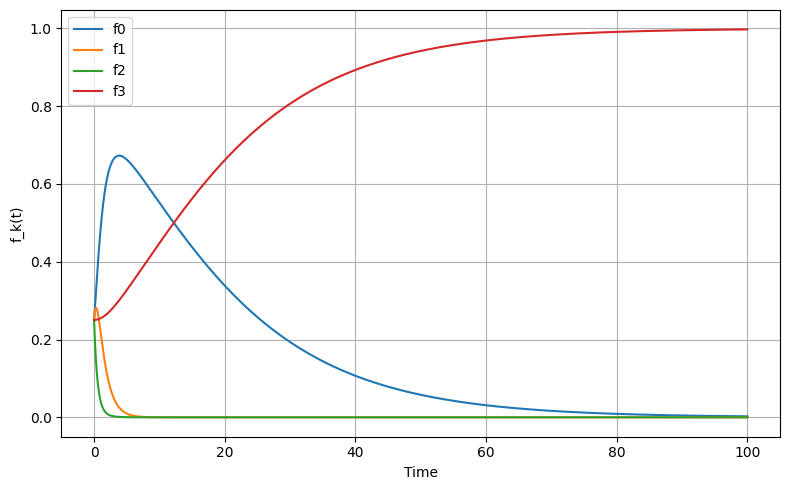

Equilibrium point:
[-4.06038605e-23 -1.09270123e-23 -1.22125043e-24  1.00000000e+00] 

Eigenvalues of Jacobian:
[-6.32119694e-02 -2.19940030e-24 -9.22751509e-01 -1.97713443e+00] 

=> Equilibrium is STABLE.


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import numpy.linalg as LA

# R, S, T, P = 6, 5, 12, 3
R, S, T, P = 6, 3, 12, 5 #PD
omega_I = 1
omega_G = 1
Lambda = 0.1

def pi_C(x):
    return x*R + (1-x)*S

def pi_D(x):
    return x*T + (1-x)*P

def G(x):
    return x*pi_C(x) + (1-x)*pi_D(x)


# Precompute W1, W2
W1 = np.exp(omega_I * (R+2*S)/3) + 2*np.exp(omega_I * (T+2*P)/3)
W2 = 2*np.exp(omega_I * (2*R+S)/3) + np.exp(omega_I * (2*T+P)/3)
def dfdt(f):
    f0, f1, f2, f3 = f

    # denominator D
    D = (
        f0*np.exp(omega_G*P)
        + f1*np.exp(omega_G*(R+2*S+2*T+4*P)/9)
        + f2*np.exp(omega_G*(4*R+2*S+2*T+P)/9)
        + f3*np.exp(omega_G*R)
    )

    # df0
    df0 = (
        f1 * (2*np.exp(omega_I*pi_D(1/3)) / W1)
        + Lambda * f0 * (np.exp(omega_G*P)/D - 1)
    )

    # df1
    df1 = (
        -f1*(2*np.exp(omega_I*(T+2*P)/3)/W1)
        -f1*(2*np.exp(omega_I*(R+2*S)/3)/W1)
        + f2*(2*np.exp(omega_I*(2*T+P)/3)/W2)
        + Lambda*f1*(np.exp(omega_G*(R+2*S+2*T+4*P)/9)/D - 1)
    )

    # df2
    df2 = (
        -f2*(2*np.exp(omega_I*(2*T+P)/3)/W2)
        -f2*(2*np.exp(omega_I*(2*R+S)/3)/W2)
        + f1*(2*np.exp(omega_I*(R+2*S)/3)/W1)
        + Lambda*f2*(np.exp(omega_G*(4*R+2*S+2*T+P)/9)/D - 1)
    )

    # df3
    df3 = (
        f2*(2*np.exp(omega_I*(2*R+S)/3)/W2)
        + Lambda*f3*(np.exp(omega_G*R)/D - 1)
    )

    return np.array([df0, df1, df2, df3])

def rk4_step(f, dt):
    k1 = dfdt(f)
    k2 = dfdt(f + dt*k1/2)
    k3 = dfdt(f + dt*k2/2)
    k4 = dfdt(f + dt*k3)
    f_new = f + dt*(k1 + 2*k2 + 2*k3 + k4)/6
    return f_new / np.sum(f_new)


Tmax = 100
dt = 0.001
steps = int(Tmax/dt)

# initial condition (must sum to 1)
f = np.array([0.25, 0.25, 0.25, 0.25])
history = np.zeros((steps, 4))
time = np.linspace(0, Tmax, steps)

for i in range(steps):
    history[i] = f
    f = rk4_step(f, dt)


plt.figure(figsize=(8,5))
plt.plot(time, history[:,0], label="f0")
plt.plot(time, history[:,1], label="f1")
plt.plot(time, history[:,2], label="f2")
plt.plot(time, history[:,3], label="f3")
plt.xlabel("Time")
plt.ylabel("f_k(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#eq points
def equilibrium_equations(f):
    f0, f1, f2, f3 = f
    S = f0 + f1 + f2 + f3
    if S == 0:
        return np.array([1,1,1,1]) 
    f = f / S
    return dfdt(f)
f_guess = np.array([0.25, 0.25, 0.25, 0.25])
eq_f, info, ier, msg = fsolve(equilibrium_equations, f_guess, full_output=True)
eq_f = eq_f / np.sum(eq_f)
print("Equilibrium point:")
print(eq_f, "\n")

#stability
def jacobian(f, eps=1e-6):
    n = len(f)
    J = np.zeros((n,n))
    F0 = dfdt(f)
    
    for j in range(n):
        f_perturb = f.copy()
        f_perturb[j] += eps
        f_perturb /= np.sum(f_perturb)
        F1 = dfdt(f_perturb)
        J[:, j] = (F1 - F0) / eps

    return J
J_eq = jacobian(eq_f)
# print("Jacobian at equilibrium:")
# print(J_eq, "\n")
eigvals, eigvecs = LA.eig(J_eq)
print("Eigenvalues of Jacobian:")
print(eigvals, "\n")

if np.all(np.real(eigvals) < 0):
    print("=> Equilibrium is STABLE.")
elif np.any(np.real(eigvals) > 0):
    print("=> Equilibrium is UNSTABLE.")
else:
    print("=> Equilibrium is NON-HYPERBOLIC (zero real parts).")
